In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math

from sklearn import linear_model
from random import shuffle
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

In [67]:
df_music = pd.read_csv('../music_data/dataset-12-1.csv')

In [68]:
df_music.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114


# 0 Utility

In [69]:
def z_score_norm(df, feature_list):
    """ Do the z-score method on selected features in feature_list. 
        z = (x - mean)/std

    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())
        
        
        
def do_log(df, feature_list):
    '''Do logarithm on selected features in feature_list.
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    '''
    
    for col in feature_list:
        df[col] = np.log(df[col])
        
        
        
def powerlaw_rank(df_music):
    ''' Do powerlaw on the original rank.
        y = 100*rank^(-0.66)
        However, I find that differnent coefficient and exponent do not affect MAE. Don't know why.
    
    Args:
        df_music (pandas.DataFrame): dataset
    '''
    
    df_music.insert(1, 'RankPowerlaw', df_music.Rank)  # insert right next to column 'Rank'
    df_music['RankPowerlaw'] = df_music['RankPowerlaw'].astype('float')
    for i in range(0, len(df_music)):
        df_music.iat[i,1] = 100 * math.pow(df_music.iat[i,1], -0.66)

In [70]:
def performance_statistics(model_name, target, pred):
    '''Plot a table of performance statistics
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    mae   = mean_absolute_error(target, pred)
    medae = median_absolute_error(target, pred)
    r2    = r2_score(target, pred)
    
    columns = ['Model', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score']
    cell_text = [['%s' % model_name, '%1.3f' % mae, '%1.3f' % medae, '%1.3f' % r2]]
    
    nrow = 1
    ncol = len(columns)
    
    fig = plt.figure(figsize=(ncol*2, nrow*0.2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center')
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    
    
    
def error_distribution(model_name, target, pred):
    '''Plot a histogram of the error distribution
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    err = pred - target   # error is a Series
    min_err = err.min()
    max_err = err.max()
    fig = plt.figure()
    ax = err.plot.hist(bins=20, figsize=(7,7), edgecolor='black')
    ax.set_xticks(np.arange(math.floor(min_err), math.ceil(max_err)))
    ax.set_title('%s - Error Distribution' % model_name, fontsize=18)
    ax.set_xlabel('Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.grid()
    
    fig.savefig('../figure/%s_error_dist.png' % model_name)
    
    

def prediction_error_map(model_name, target, pred):
    '''Plot the prediction error map (similar to confusion matrices in classification problems)
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    y_min = target.min()*0.98
    y_max = target.max()*1.01
    fig, ax = plt.subplots(figsize=(7,7))
    #plt.scatter(target, pred, edgecolor='black', s=15)
    plt.scatter(target, pred, s=13)
    ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)
    ax.set_xticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_yticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_title('%s - Prediction Error Map' % model_name, fontsize=18)
    #ax.set_xlabel('Real Spotify (log) Play Count', fontsize=14)
    ax.set_xlabel('Target', fontsize=14)
    ax.set_ylabel('Prediction', fontsize=14)
    #ax.axis([y_min,y_max,y_min,y_max])
    ax.grid()
    
    fig.savefig('../figure/%s_error_map.png' % model_name)
    
    
    
def permutation_test(model,target,pred):
    '''do permuation tests
    
    Args:
        model_name: model
        target (Series):  target data
        pred   (ndarray): predition results
    ''' 
    pred = cross_val_predict(model, X=feature, y=target, cv=10)
    mae  = mean_absolute_error(target,pred)
    mae_list=[mae]
    count=0
    while count<100:
        count = count+1 
        target_to_list = target.tolist()
        shuffle(target_to_list)
        target_per = pd.DataFrame({'playcount':target_to_list})
        pred1 = cross_val_predict(model, X=feature, y=target_per, cv=10)
        mae_shuffle = mean_absolute_error(target,pred1)
        mae_list.append(mae_shuffle)
    num_bins = 20
    fig, ax = plt.subplots(figsize=(7,7))
    n, bins, patches = ax.hist(mae_list, num_bins)
    ax.set_title('Permutation test')
    ax.set_xlabel('$Log(playcount)-mae$', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.get_children()[0].set_color('r')
    ax.grid()
    
    
    
def evaluation(model, feature, target):
    """ Run the model on X and y using cross validation. Then output:
        1) performance statistics
        2) error distributions
        3) prediction error map
        
    Args:
        model   (object):    the machine learning object to fit the data
        feature (DataFrame): feature data
        target  (Series):    target  data
        
    This is version 0.11.10 (Nov. 10th)
    
    Todo:
        parameter "model" should be a list of models in the future
    """
    
    model_name = str(model)        # 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)'
    end = model_name.find('(')
    model_name = model_name[0:end] # 'LinearRegression'
    
    '''Do the prediction by cross validation'''
    pred = cross_val_predict(model, X=feature, y=target, cv=10)  # default is 10-fold
    
    print('This is the plots/reports of %s'  % model_name)
        
    error_distribution(model_name, target, pred)
    
    prediction_error_map(model_name, target, pred)
    
    #permutation_test(model, target, pred)
    
    performance_statistics(model_name, target, pred)    

# 1 Baseline

In [71]:
df_music.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114


In [72]:
do_log(df_music, feature_list=['RankPowerlaw', 'SpotifyPlayCount', 'WikiWordCount'])

In [73]:
z_score_norm(df_music, feature_list=['Rank', 'RankPowerlaw', 'Year', 'WikiWordCount'])

In [74]:
feature = df_music.loc[:,['Rank', 'Year', 'WikiWordCount']]
target  = df_music.loc[:,['SpotifyPlayCount']]

In [75]:
lr = linear_model.LinearRegression()

In [76]:
reg = linear_model.Ridge (alpha = .8)

This is the plots/reports of LinearRegression


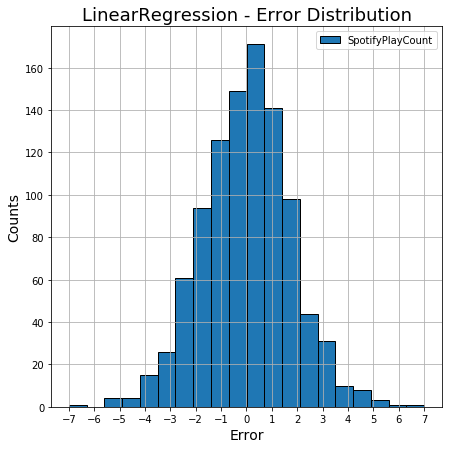

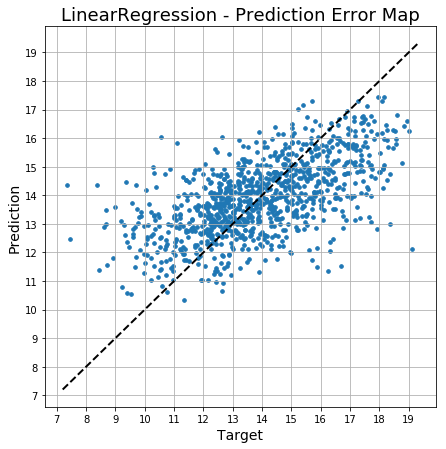

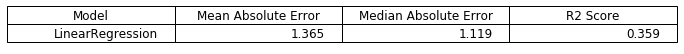

In [77]:
evaluation(lr, feature, target)

In [78]:
pred = cross_val_predict(lr, X=feature, y=target, cv=10)  # default is 10-fold

# Twenty Best

In [79]:
def top20BetterThanPrediction(pred, target):
    array = target - pred

In [80]:
best = target - pred

In [81]:
best.insert(0, 'Prediction', pred)

In [82]:
best.insert(0, 'Target', target)

In [83]:
best.describe()

,Target,Prediction,SpotifyPlayCount
count,988.000000,988.000000,988.000000
mean,13.887698,13.890678,-0.002980
std,2.178420,1.310333,1.744677
min,7.348588,10.348694,-7.001653
25%,12.424427,12.994402,-1.110710
50%,13.752248,13.849127,-0.042655
75%,15.432659,14.777470,1.125359
max,19.119101,17.457280,6.997500


In [84]:
best_index = best.nlargest(20, columns='SpotifyPlayCount').index

In [85]:
best.nlargest(20, columns='SpotifyPlayCount')

,Target,Prediction,SpotifyPlayCount
826,19.119101,12.121600,6.997500
91,18.355697,12.994171,5.361527
180,16.674597,11.515614,5.158983
259,17.907229,12.811189,5.096040
125,16.255563,11.350880,4.904683
276,17.717049,13.056824,4.660224
872,17.636537,13.228944,4.407593
179,15.887576,11.493394,4.394182
387,16.316187,12.064915,4.251272
842,17.322973,13.196334,4.126639


In [86]:
df_music.iloc[best_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
826,1.261736,-0.898481,Marvin Gaye and Tammi Terrell,Ain't No Mountain High Enough,0.861304,19.119101,-1.174319
91,1.019934,-0.807624,Sam Cooke,Wonderful World,-1.568050,18.355697,0.368819
180,1.641711,-1.027442,Maurice Williams and the Zodiacs,Stay,-1.568050,16.674597,-0.879062
259,0.432699,-0.548864,Ben E. King,Stand By Me,-1.221000,17.907229,-0.295543
125,0.018181,-0.319982,Billy Bland,Let The Little Girl Dance,-1.568050,16.255563,-1.928618
276,1.538082,-0.993766,Dave Brubeck,Take Five,-1.221000,17.717049,0.585683
872,1.054477,-0.821079,Cream,White Room,1.208354,17.636537,-0.369916
179,1.607168,-1.016333,Barrett Strong,Money,-1.568050,15.887576,-0.918794
387,1.641711,-1.027442,The Chiffons,One Fine Day,-0.526899,16.316187,-0.659315
842,-0.085449,-0.254315,Scott Mckenzie,San Francisco (Be Sure to Wear Flowers in Your...,0.861304,17.322973,-0.934127


In [87]:
lr2 = linear_model.LinearRegression()

In [88]:
lr2.fit(feature, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [89]:
feature.head()

,Rank,Year,WikiWordCount
0,-1.708980,-1.56805,-0.493528
1,-1.674437,-1.56805,0.735464
2,-1.639893,-1.56805,0.706477
3,-0.707227,-1.56805,0.706477
4,0.674502,-1.56805,0.706477


In [90]:
lr2.coef_

array([[-0.58460635,  0.39034031,  1.04953815]])

# Twenty Worst

In [91]:
best.nsmallest(20, columns='SpotifyPlayCount')

,Target,Prediction,SpotifyPlayCount
957,7.348588,14.350241,-7.001653
737,8.377471,14.370977,-5.993506
578,10.539509,16.025878,-5.486369
515,9.375601,14.461606,-5.086006
227,7.454720,12.456897,-5.002177
519,8.679822,13.476579,-4.796756
960,10.271043,14.994031,-4.722988
715,11.114401,15.829531,-4.715130
864,9.691964,14.376161,-4.684197
747,8.977146,13.591947,-4.614801


In [92]:
worst_index = best.nsmallest(20, columns='SpotifyPlayCount').index

In [93]:
df_music.iloc[worst_index, :]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
957,-0.776313,0.329507,Andy Kim,"Baby, I Love You",1.555405,7.348588,-0.648729
737,1.710798,-1.049325,Paul Revere and The Raiders,Let Me,1.555405,8.377471,0.719238
578,0.225440,-0.440457,The Temptations,"Run Away Child, Running Wild",1.555405,10.539509,1.512541
515,-1.087202,0.749521,The Ray Charles Singers,Love Me with All Your Heart (Cuando Calienta E...,-0.179848,9.375601,-0.038870
227,-0.499967,0.057292,Linda Scott,Don't Bet Money Honey,-1.221000,7.454720,-1.180957
519,0.570872,-0.615542,The Dave Clark Five,Can't You See That She's Mine,-0.179848,8.679822,-0.030284
960,-0.327251,-0.083577,Bobby Sherman,Little Woman,1.555405,10.271043,0.241225
715,-1.329005,1.247271,Roger Williams,Born Free,0.514253,11.114401,0.916863
864,1.434452,-0.959009,Bill Cosby,Little Ole Man (Uptight-Everything's Alright),0.861304,9.691964,1.031015
747,-0.465424,0.027615,Sandy Posey,Born a Woman,0.514253,8.977146,-0.716117


## Spotipy

In [94]:
import spotipy

In [95]:
spotify = spotipy.Spotify()

In [96]:
import numpy as np
import pandas as pd
import warnings

import wikipedia

In [97]:
wikipedia.search("Barack")

['Barack Obama',
 'Barack Obama Sr.',
 'Family of Barack Obama',
 'Efforts to impeach Barack Obama',
 'Protests against Barack Obama',
 'Barack (disambiguation)',
 'Early life and career of Barack Obama',
 "Confirmations of Barack Obama's Cabinet",
 'Barack Obama "Hope" poster',
 'Barack Obama Presidential Center']

In [98]:
song_df=pd.read_csv('../music_data/dataset-12-1.csv')

In [99]:
title=song_df['Title']

In [100]:
ny = wikipedia.page("He'll Have To Go")

In [101]:
grammy_df=pd.read_csv('../music_data/Grammy.csv')

In [145]:
grammy_df

,Year,Awards,Title,Artist
0,2015,Record Of The Year,Uptown Funk,Bruno Mars
1,2015,Song Of The Year,Thinking Out Loud,Ed Sheeran
2,2015,Best Pop Solo Performance,Thinking Out Loud,Ed Sheeran
3,2015,Best Pop Duo/Group Performance,Uptown Funk,Bruno Mars
4,2015,Best Dance Recording,Where Are Ü Now,Justin Bieber
5,2015,Best Rock Performance,Don't Wanna Fight,Alabama Shakes
6,2015,Best Metal Performance,Cirice,Ghost
7,2015,Best Rock Song,Don't Wanna Fight,Alabama Shakes
8,2015,Best R&B Performance,Earned It (Fifty Shades Of Grey),The Weeknd
9,2015,Best Traditional R&B Performance,Little Ghetto Boy,Lalah Hathaway


In [103]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [104]:
fuzz.ratio("this is a test", "this is a test!")

97

In [105]:
import difflib 

In [258]:
df_1=pd.read_csv('../music_data/dataset-12-1.csv')
df_2=pd.read_csv('../music_data/Grammy.csv')
grammy_awards=df_2.loc[df_2['Year'].isin(['1960','1961','1962','1963','1964','1965','1966','1967','1968','1969','1970'])]
df_1['GrammyAwards']=None

In [259]:
df_3=df_1.merge(df_2, how='left', on='Title')

In [261]:
df_3.to_csv('addgrammy2.csv')

In [263]:
grammy_new=pd.read_csv('../src/addgrammy2.csv')

In [270]:
grammy=grammy_new.drop_duplicates(['Artist_x','Title'])

In [271]:
grammy

,Unnamed: 0,Rank,RankPowerlaw,Artist_x,Title,Year_x,SpotifyPlayCount,WikiWordCount,Year_awards,Awards,Artist_award,awardscore
0,518,11,20.543802,Barbra Streisand,People,1964,1096736,9030,1964.0,Best Accompaniment Arrangement For Vocalist(s)...,Peter Matz,1.0
1,343,60,6.705330,Henry Mancini,Moon River,1962,2813365,2486,1961.0,Best Arrangement,Henry Mancini,1.0
2,814,3,48.428383,Bobby Gentry,Ode To Billie Joe,1967,170998,1880,1967.0,Best Arrangement Accompanying A Vocalist Or In...,Jimmie Haskell,1.0
3,983,27,11.357949,"Blood, Sweat and Tears",Spinning Wheel,1969,4195660,940,1969.0,Best Arrangement Accompanying Vocalist(s),Fred Lipsius,1.0
4,473,82,5.456107,Allan Sherman,"Hello Muddah, Hello Faddah! (A Letter from Camp)",1963,445104,3735,1963.0,Best Comedy Performance,Allan Sherman,1.0
5,724,7,27.684411,The Mamas and The Papas,"Monday, Monday",1966,16358219,5544,1966.0,"Best Contemporary (R&R) Group Performance, Voc...",Mamas And The Papas,2.0
6,735,18,14.842947,The New Vaudeville Band,Winchester Cathedral,1966,312103,415,1966.0,"Best Contemporary (R&R) Group Performance, Voc...",New Vaudeville Band,2.0
7,974,15,16.740937,Henry Mancini and His Orch.,Love Theme From Romeo And Juliet,1969,1011300,2486,1969.0,Best Contemporary Performance By A Chorus,Percy Faith Chorus,1.0
8,776,9,23.453083,Simon and Garfunkel,Mrs. Robinson,1968,111152876,5561,1968.0,Best Contemporary Pop Performance - Vocal Duo ...,Simon And Garfunkel,1.0
9,934,43,8.354314,Mason Williams,Classical Gas,1968,2922557,1908,1968.0,"Best Contemporary Pop Performance, Instrumental",Mason Williams,1.0


In [269]:
grammy_new.to_csv('grammy_new.csv')

In [251]:
def match(Col1,Col2,df_1,grammy_awards):
    overall=[]
    for n in Col1:
        result=[(fuzz.partial_ratio(n, n2),n2) 
                for n2 in Col2 if fuzz.partial_ratio(n, n2)>95
               ]
        if len(result):
            result.sort()    
            print('result {}'.format(result))
            print("Best M={}".format(result[-1][1]))
            overall.append(n)
            overall.append(result[-1][1])
            df_1.loc[df_1['Title'] == n,'Title']=result[-1][1]
            #df_1[df_1['Title']==n].GrammyAwards=grammy_awards[grammy_awards['Title']==result[-1][1]].Awards
        else:
            overall.append(" ")
    return overall

In [252]:
overall=match(df_1.Title,grammy_awards.Title,df_1,grammy_awards)

result [(96, 'The Theme From A Summer Place')]
Best M=The Theme From A Summer Place
result [(100, 'Let It Be')]
Best M=Let It Be
result [(100, "Let's Twist Again")]
Best M=Let's Twist Again
result [(100, 'El Paso')]
Best M=El Paso
result [(100, 'Crying Time'), (100, 'Crying Time')]
Best M=Crying Time
result [(100, 'Why I Oppose The War In Vietnam'), (100, 'Why Is There Air?')]
Best M=Why Is There Air?
result [(100, 'If I Were A Carpenter')]
Best M=If I Were A Carpenter
result [(100, "A Hard Day's Night"), (100, 'Strangers In The Night'), (100, 'Strangers In The Night'), (100, 'Strangers In The Night'), (100, 'Strangers In The Night')]
Best M=Strangers In The Night
result [(100, 'Theme From Exodus')]
Best M=Theme From Exodus
result [(100, 'Hit The Road Jack')]
Best M=Hit The Road Jack
result [(100, 'Bernstein Conducts For Young People')]
Best M=Bernstein Conducts For Young People
result [(100, "Didn't I (Blow Your Mind This Time)"), (100, "This Time By Basie! Hits Of The 50's And 60's")

In [253]:
df_grammy=df_1.merge(grammy_awards, how='left', on='Title')

In [255]:
df_grammy.to_csv('addgrammy.csv')

In [191]:
df_1=pd.read_csv('../music_data/dataset-12-1.csv')

In [192]:
df_2=pd.read_csv('../music_data/Grammy.csv')

In [110]:
result = pd.merge(df_1, df_2, how='left', on=['Title'])

In [193]:
grammy_awards=df_2.loc[df_2['Year'].isin(['1960','1961','1962','1963','1964','1965','1966','1967','1968','1969'])]

In [194]:
grammy_awards

,Year,Awards,Title,Artist
2182,1969,Record Of The Year,Aquarius/Let The Sunshine In (The Flesh Failures),5th Dimension
2183,1969,Song Of The Year,Games People Play,Joe South
2184,1969,Best Instrumental Arrangement,Love Theme From Romeo And Juliet,Henry Mancini
2185,1969,Best Arrangement Accompanying Vocalist(s),Spinning Wheel,Fred Lipsius
2186,1969,Best Engineered Recording - Non-Classical,Abbey Road,Geoff E. Emerick
2187,1969,"Best Contemporary Vocal Performance, Female",Is That All There Is?,Peggy Lee
2188,1969,"Best Contemporary Vocal Performance, Male",Everybody's Talkin',Harry Nilsson
2189,1969,Best Contemporary Vocal Performance By A Group,Aquarius/Let The Sunshine In (The Flesh Failures),5th Dimension
2190,1969,Best Contemporary Performance By A Chorus,Love Theme From Romeo And Juliet,Percy Faith Chorus
2191,1969,Best Contemporary Instrumental Performance,Variations On A Theme By Eric Satie,Blood


In [197]:
def match(Col1,Col2,df_1,grammy_awards):
    overall=[]
    for n in Col1:
        result=[(fuzz.partial_ratio(n, n2),n2) 
                for n2 in Col2 if fuzz.partial_ratio(n, n2)>90
               ]
        if len(result):
            result.sort()    
            print('result {}'.format(result))
            print("Best M={}".format(result[-1][1]))
            overall.append(n)
            overall.append(result[-1][1])
            df_1.loc[df_1['Title'] == n,'Title']=result[-1][1]
            #df_1[df_1['Title']==n].GrammyAwards=grammy_awards[grammy_awards['Title']==result[-1][1]].Awards
        else:
            overall.append(" ")
    return overall

In [154]:
df_1['GrammyAwards']=None

In [198]:
overall=match(df_1.Title,grammy_awards.Title,df_1,grammy_awards)

result [(96, 'The Theme From A Summer Place')]
Best M=The Theme From A Summer Place
result [(100, "Let's Twist Again")]
Best M=Let's Twist Again
result [(100, 'El Paso')]
Best M=El Paso
result [(100, 'Crying Time'), (100, 'Crying Time')]
Best M=Crying Time
result [(100, 'Why Is There Air?')]
Best M=Why Is There Air?
result [(91, "It's Your Thing")]
Best M=It's Your Thing
result [(100, "A Hard Day's Night"), (100, 'Strangers In The Night'), (100, 'Strangers In The Night'), (100, 'Strangers In The Night'), (100, 'Strangers In The Night')]
Best M=Strangers In The Night
result [(100, 'Theme From Exodus')]
Best M=Theme From Exodus
result [(100, 'Hit The Road Jack')]
Best M=Hit The Road Jack
result [(100, 'Bernstein Conducts For Young People')]
Best M=Bernstein Conducts For Young People
result [(91, 'Spinning Wheel')]
Best M=Spinning Wheel
result [(100, "This Time By Basie! Hits Of The 50's And 60's")]
Best M=This Time By Basie! Hits Of The 50's And 60's
result [(100, "Goin' Out Of My Head")

In [199]:
df_1

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
0,1,100.000000,Percy Faith,The Theme From A Summer Place,1960,5001152,1180
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114
5,91,5.093692,The Everly Brothers,When Will I Be Loved,1960,508098,4114
6,57,6.936216,The Everly Brothers,Walk Right Back,1961,2192314,4114
7,47,7.877990,The Everly Brothers,Crying In The Rain,1962,3014478,4114
8,4,40.053494,Johnny Preston,Running Bear,1960,1444980,444
9,45,8.107365,Johnny Preston,Cradle Of Love,1960,232921,444


In [200]:
new_df = pd.merge(df_1, grammy_awards,  how='left', left_on=['Title'], right_on = ['Title'])

In [144]:
new_df.to_csv('mergegrammy.csv')

In [206]:
df_grammy=df_1.merge(grammy_awards, how='left', on='Title')

In [210]:
df_grammy.to_csv('addgrammy.csv')

In [256]:
df_3=df_1.merge(df_2, how='left', on='Title')

In [257]:
df_3

,Rank,RankPowerlaw,Artist_x,Title,Year_x,SpotifyPlayCount,WikiWordCount,GrammyAwards,Year_y,Awards,Artist_y
0,1,100.000000,Percy Faith,The Theme From A Summer Place,1960,5001152,1180,None,1960.0,Record Of The Year,Percy Faith
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240,None,NaN,NaN,NaN
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114,None,NaN,NaN,NaN
3,30,10.594976,The Everly Brothers,Let It Be,1960,697716,4114,None,1970.0,Best Original Score Written For A Motion Pictu...,George Harrison
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114,None,NaN,NaN,NaN
5,91,5.093692,The Everly Brothers,When Will I Be Loved,1960,508098,4114,None,NaN,NaN,NaN
6,57,6.936216,The Everly Brothers,Walk Right Back,1961,2192314,4114,None,NaN,NaN,NaN
7,47,7.877990,The Everly Brothers,Crying In The Rain,1962,3014478,4114,None,NaN,NaN,NaN
8,4,40.053494,Johnny Preston,Running Bear,1960,1444980,444,None,NaN,NaN,NaN
9,45,8.107365,Johnny Preston,Cradle Of Love,1960,232921,444,None,NaN,NaN,NaN


In [215]:
df_grammy2=df_grammy

In [216]:
df_grammy2.groupby(["Artist_x", "Title"])

In [219]:
df_grammy2

,Rank,RankPowerlaw,Artist_x,Title,Year_x,SpotifyPlayCount,WikiWordCount,Year_y,Awards,Artist_y
0,1,100.000000,Percy Faith,The Theme From A Summer Place,1960,5001152,1180,1960.0,Record Of The Year,Percy Faith
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240,NaN,NaN,NaN
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114,NaN,NaN,NaN
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114,NaN,NaN,NaN
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114,NaN,NaN,NaN
5,91,5.093692,The Everly Brothers,When Will I Be Loved,1960,508098,4114,NaN,NaN,NaN
6,57,6.936216,The Everly Brothers,Walk Right Back,1961,2192314,4114,NaN,NaN,NaN
7,47,7.877990,The Everly Brothers,Crying In The Rain,1962,3014478,4114,NaN,NaN,NaN
8,4,40.053494,Johnny Preston,Running Bear,1960,1444980,444,NaN,NaN,NaN
9,45,8.107365,Johnny Preston,Cradle Of Love,1960,232921,444,NaN,NaN,NaN


In [222]:
#df['text'] = df[['name','text','month']].groupby(['name','month'])['text'].transform(lambda x: ','.join(x))
df_grammy2.groupby(['Artist_x','Title'])['Awards']

In [224]:
df_grammy2['awardscore']=None

In [247]:
df_grammy2.Awards = df_grammy2.Awards.astype(str)
df_grammy2.Artist_x = df_grammy2.Artist_x.astype(str)

In [249]:
df_grammy2

,Rank,RankPowerlaw,Artist_x,Title,Year_x,SpotifyPlayCount,WikiWordCount,Year_y,Awards,Artist_y,awardscore
0,1,100.000000,Percy Faith,The Theme From A Summer Place,1960,5001152,1180,1960.0,Record Of The Year,Percy Faith,None
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240,NaN,nan,NaN,None
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114,NaN,nan,NaN,None
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114,NaN,nan,NaN,None
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114,NaN,nan,NaN,None
5,91,5.093692,The Everly Brothers,When Will I Be Loved,1960,508098,4114,NaN,nan,NaN,None
6,57,6.936216,The Everly Brothers,Walk Right Back,1961,2192314,4114,NaN,nan,NaN,None
7,47,7.877990,The Everly Brothers,Crying In The Rain,1962,3014478,4114,NaN,nan,NaN,None
8,4,40.053494,Johnny Preston,Running Bear,1960,1444980,444,NaN,nan,NaN,None
9,45,8.107365,Johnny Preston,Cradle Of Love,1960,232921,444,NaN,nan,NaN,None


In [238]:
for n in df_grammy2.Awards:
       if n=='Record Of The Year' 
        df_grammy2[i].awardscore=2
    #else if df_grammy2[i].Awards=='Song Of The Year' 
         #df_grammy2[i].awardscore=2
    #else if df_grammy2[i].Awards!=None && df_grammy2[i].Awards!='Record Of The Year' && df_grammy2[i].Awards=='Song Of The Year'
         #df_grammy2[i].awardscore=1 
    #else 
         #df_grammy2[i].awardscore=0   


SyntaxError: invalid syntax (<ipython-input-238-558ae69b6ade>, line 2)